In [1]:
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

SEED = 42
torch.manual_seed(SEED)

# Custom loss function
def custom_loss(gamma, sigma, output, target):
    p = torch.rand(output.shape).to(device)
    
    def weight_form(alpha):
        return (p**alpha)/(p**alpha + (1-p)**alpha)**(1/alpha)
    
    #agg_pi = weight_form(gamma) + weight_form(sigma)
    loss = (output - target)**2 #* agg_pi
    mean_loss = torch.mean(loss)
    return mean_loss, loss

# Custom loss function
def ws_loss(output, target):
    loss = (output - target)**2
    mean_loss = torch.mean(loss)
    return mean_loss, loss

# Define neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(100, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Model Parameters
gamma = 0.0
sigma = 0.0
    
# Load datasets
X = np.loadtxt('SynData/features10.csv', delimiter=',')
y = np.loadtxt('SynData/alllabels10.csv', delimiter=',', dtype=np.int32)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Convert the NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets for train and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for train and test sets
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate neural network model and optimizer, and move them to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Train the model
model.train()
for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss, _ = custom_loss(
            gamma, sigma, output, 
            nn.functional.one_hot(target, num_classes=2).float().to(device)
        )
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# Test the model and track losses of misclassified samples
# Configure logging
logging.basicConfig(filename='logs/DeepSynthetic_g{:.2f}_s{:.2f}_seed{:.0f}.txt'.format(gamma, sigma, SEED), level=logging.INFO, format='%(asctime)s %(levelname)s:%(message)s')

model.eval()
test_loss = 0
correct = 0
misclassified_losses = [] # list to store losses of misclassified samples
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss, sample_losses = ws_loss(output, nn.functional.one_hot(target, num_classes=2).float().to(device))
        test_loss += loss.item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        for i in range(len(target)):
            if pred[i] != target[i]:
                misclassified_losses.append(torch.mean(sample_losses[i]).item()) # add loss of misclassified sample to list

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.10f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    # Log the output
    logging.info('Test set: Average loss: {:.10f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


Train Epoch: 0 [0/4000 (0%)]	Loss: 0.997660
Train Epoch: 0 [1600/4000 (40%)]	Loss: 0.357588
Train Epoch: 0 [3200/4000 (80%)]	Loss: 0.299305
Train Epoch: 1 [0/4000 (0%)]	Loss: 0.310925
Train Epoch: 1 [1600/4000 (40%)]	Loss: 0.220465
Train Epoch: 1 [3200/4000 (80%)]	Loss: 0.313407
Train Epoch: 2 [0/4000 (0%)]	Loss: 0.256342
Train Epoch: 2 [1600/4000 (40%)]	Loss: 0.195941
Train Epoch: 2 [3200/4000 (80%)]	Loss: 0.281588
Train Epoch: 3 [0/4000 (0%)]	Loss: 0.233033
Train Epoch: 3 [1600/4000 (40%)]	Loss: 0.199784
Train Epoch: 3 [3200/4000 (80%)]	Loss: 0.160057
Train Epoch: 4 [0/4000 (0%)]	Loss: 0.180981
Train Epoch: 4 [1600/4000 (40%)]	Loss: 0.242897
Train Epoch: 4 [3200/4000 (80%)]	Loss: 0.180051
Train Epoch: 5 [0/4000 (0%)]	Loss: 0.177185
Train Epoch: 5 [1600/4000 (40%)]	Loss: 0.275340
Train Epoch: 5 [3200/4000 (80%)]	Loss: 0.169917
Train Epoch: 6 [0/4000 (0%)]	Loss: 0.222345
Train Epoch: 6 [1600/4000 (40%)]	Loss: 0.215901
Train Epoch: 6 [3200/4000 (80%)]	Loss: 0.176033
Train Epoch: 7 [0/40

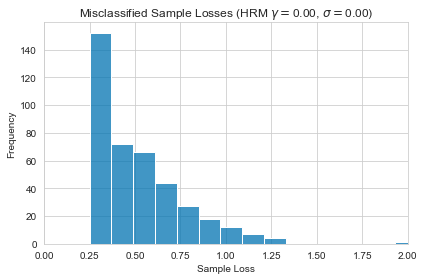

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_palette("colorblind")

# Plot histogram of misclassified sample losses
plt.figure(figsize=(6, 4))
sns.histplot(misclassified_losses, kde=False, bins=15)
plt.xlabel("Sample Loss")
plt.ylabel("Frequency")
plt.title("Misclassified Sample Losses (HRM $\gamma = ${:.2f}, $\sigma = ${:.2f})".format(gamma, sigma))
plt.xlim([0, 2]) # set the range of the x-axis
plt.tight_layout()
plt.savefig('Results/DeepSynthetic_g${:.2f}_s${:.2f}_seed{:.0f}.png'.format(gamma, sigma, SEED))  # save the figure as a PNG file
plt.show()


In [3]:
# import numpy as np
# import matplotlib.pyplot as plt

# # create two histograms for losses below 1 and losses greater than or equal to 1
# losses_below_one = [loss for loss in misclassified_losses if loss < 1]
# losses_above_one = [loss for loss in misclassified_losses if loss >= 1]

# fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# # plot histogram for losses below 1
# n1, bins1, patches1 = axs[0].hist(losses_below_one, bins=20, range=(0, 1), color='red')
# axs[0].set_title("Misclassified Sample Losses < 1")
# axs[0].set_xlabel("Loss")
# axs[0].set_ylabel("Frequency")

# # plot histogram for losses greater than or equal to 1
# n2, bins2, patches2 = axs[1].hist(losses_above_one, bins=20, range=(1, max(misclassified_losses)), color='blue')
# axs[1].set_title("Misclassified Sample Losses >= 1")
# axs[1].set_xlabel("Loss")
# axs[1].set_ylabel("Frequency")

# # set x-axis range to be fixed between 0 and the maximum loss value
# plt.xlim([0, max(misclassified_losses)])
# axs[1].set_xlim(left=1)

# # display plot
# plt.tight_layout()
# plt.show()
